<a href="https://colab.research.google.com/github/alvitohawari/Hands-on-Machine-Learning-with-Scikit-Learn-Keras-TensorFlow/blob/main/Chapter_12_custom_models_and_training_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 12  
## Custom Models and Training with TensorFlow

---

## 1. Overview
This chapter explains how to move beyond TensorFlow’s high-level API (**tf.keras**) and use **low-level TensorFlow features** when greater flexibility and control are required. While tf.keras is sufficient for most use cases, advanced scenarios need custom implementations of **loss functions, metrics, layers, models, and training loops**.

---

## 2. TensorFlow Architecture
- TensorFlow is a numerical computation library optimized for **large-scale machine learning**.
- Supports **CPU, GPU, and TPU** execution.
- Key features:
  - Automatic differentiation (autodiff)
  - Distributed computing
  - Portable computation graphs
- Core ecosystem:
  - TensorBoard
  - TensorFlow Extended (TFX)
  - TensorFlow Hub
  - TensorFlow Serving

---

## 3. Using TensorFlow Like NumPy
- `tf.Tensor` is similar to `numpy.ndarray`
- Differences from NumPy:
  - Tensors are **immutable**
  - No automatic type casting (improves performance & safety)
- Supports vectorized math operations and GPU acceleration
- Easy conversion between NumPy arrays and TensorFlow tensors

---

## 4. Variables and Data Structures
- `tf.Variable` is used for **trainable parameters**
- Supports in-place updates (`assign`, `assign_add`)
- Additional data structures:
  - SparseTensor
  - RaggedTensor
  - TensorArray
  - String tensors
  - Sets and queues

---

## 5. Custom Loss Functions
- Two approaches:
  1. Function-based loss
  2. Subclassing `keras.losses.Loss`
- Example: **Huber Loss**
- Best practices:
  - Use TensorFlow operations only
  - Return per-sample losses
  - Implement `get_config()` for model serialization

---

## 6. Custom Activation, Initializer, Regularizer, Constraint
- Can be implemented as functions or subclasses
- Used directly in Keras layers
- Subclassing is required if:
  - The component has hyperparameters
  - The model needs to be saved and reloaded

---

## 7. Custom Metrics
- Metrics are used for **evaluation**, not optimization
- Simple metrics → function-based
- Complex metrics (e.g., precision) → **stateful (streaming) metrics**
- Implemented by subclassing `keras.metrics.Metric`
- Metrics maintain internal state across batches

---

## 8. Custom Layers
- Two methods:
  - `Lambda` layer (stateless)
  - Subclassing `keras.layers.Layer` (stateful)
- Important methods:
  - `__init__`
  - `build`
  - `call`
  - `get_config`
- Supports:
  - Multiple inputs and outputs
  - Different behavior during training and inference

---

## 9. Custom Models
- Created by subclassing `keras.Model`
- Used for complex architectures (loops, skip connections)
- Models can contain custom layers
- Implement `get_config()` for full serialization support

---

## 10. Losses and Metrics Based on Model Internals
- Losses can depend on:
  - Hidden layer activations
  - Weights
  - Input reconstruction
- Use:
  - `self.add_loss()` to add custom losses
  - `self.add_metric()` to track internal metrics
- Commonly used for advanced regularization

---

## 11. Automatic Differentiation (Autodiff)
- Implemented using `tf.GradientTape`
- Records operations involving variables
- Supports:
  - Persistent tapes
  - Watching tensors
  - Stopping gradients (`tf.stop_gradient`)
  - Custom gradients (`@tf.custom_gradient`) for numerical stability

---

## 12. Custom Training Loops
Used when `model.fit()` is not sufficient, such as:
- Multiple optimizers
- Manual gradient manipulation
- Research-level experiments

Main steps:
1. Forward pass
2. Compute loss (including regularization)
3. Compute gradients
4. Apply gradients
5. Update metrics

More flexible but harder to maintain and debug.

---

## 13. TensorFlow Functions and Graphs
- `@tf.function` converts Python code into a TensorFlow computation graph
- Benefits:
  - Faster execution
  - Optimized computation
  - Cross-platform deployment
- **AutoGraph** converts Python control flow (`if`, `for`, `while`) into TensorFlow operations
- Important rules:
  - Use TensorFlow ops (not NumPy)
  - Avoid Python side effects
  - Loops must iterate over tensors

---

## 14. Key Takeaways
- `tf.keras` covers most use cases, but low-level TensorFlow provides full control
- All components (losses, metrics, layers, models) can be customized
- `GradientTape` and `tf.function` are essential for advanced training
- Custom training loops should be used only when necessary
- TensorFlow 2 greatly simplifies graph-based execution


In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X = housing.data.astype(np.float32)
y = housing.target.astype(np.float32)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_valid = scaler.transform(X_valid).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

X_train.shape, X_valid.shape, X_test.shape

((13209, 8), (3303, 8), (4128, 8))

In [ ]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        # input_shape: (batch_size, n_features)
        n_inputs = int(input_shape[-1])
        self.W = self.add_weight(
            name="W",
            shape=(n_inputs, self.units),
            initializer="glorot_uniform",
            trainable=True
        )
        self.b = self.add_weight(
            name="b",
            shape=(self.units,),
            initializer="zeros",
            trainable=True
        )
        super().build(input_shape)

    def call(self, inputs):
        z = tf.matmul(inputs, self.W) + self.b
        return self.activation(z) if self.activation is not None else z

    def get_config(self):
        config = super().get_config()
        config.update({
            "units": self.units,
            "activation": keras.activations.serialize(self.activation),
        })
        return config

# quick sanity check
layer = MyDense(5, activation="relu")
layer(tf.zeros((2, X_train.shape[1]))).shape

TensorShape([2, 5])

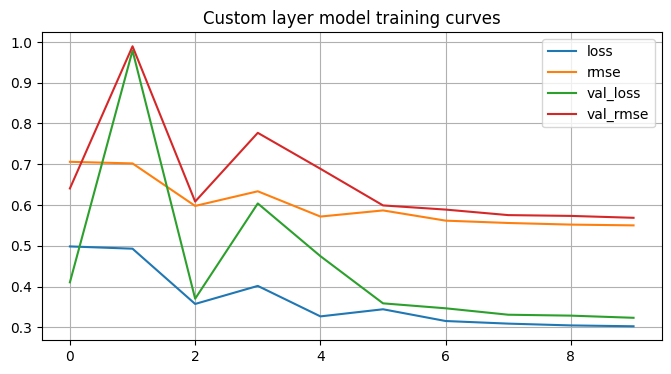

In [ ]:
inputs = keras.layers.Input(shape=(X_train.shape[1],))
x = MyDense(30, activation="relu")(inputs)
x = MyDense(30, activation="relu")(x)
outputs = keras.layers.Dense(1)(x)
custom_layer_model = keras.Model(inputs, outputs)

custom_layer_model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=[keras.metrics.RootMeanSquaredError(name="rmse")]
)

hist = custom_layer_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_valid, y_valid),
    verbose=0
)

pd.DataFrame(hist.history).plot(figsize=(8, 4), grid=True, title="Custom layer model training curves")
plt.show()

In [ ]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        abs_error = tf.abs(error)
        quadratic = tf.minimum(abs_error, self.threshold)
        linear = abs_error - quadratic
        return tf.reduce_mean(0.5 * tf.square(quadratic) + self.threshold * linear)

    def get_config(self):
        config = super().get_config()
        config.update({"threshold": self.threshold})
        return config

class MeanAbsoluteErrorMetric(keras.metrics.Metric):
    def __init__(self, name="mae_custom", **kwargs):
        super().__init__(name=name, **kwargs)
        self.total = self.add_weight(name="total", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        values = tf.abs(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32))
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            values = values * sample_weight
        self.total.assign_add(tf.reduce_sum(values))
        self.count.assign_add(tf.cast(tf.size(values), tf.float32))

    def result(self):
        return self.total / self.count

    def reset_states(self):
        self.total.assign(0.0)
        self.count.assign(0.0)

# quick sanity check
loss_fn = HuberLoss(threshold=1.0)
loss_fn(tf.constant([0.0, 2.0]), tf.constant([0.5, 0.0]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.8125>

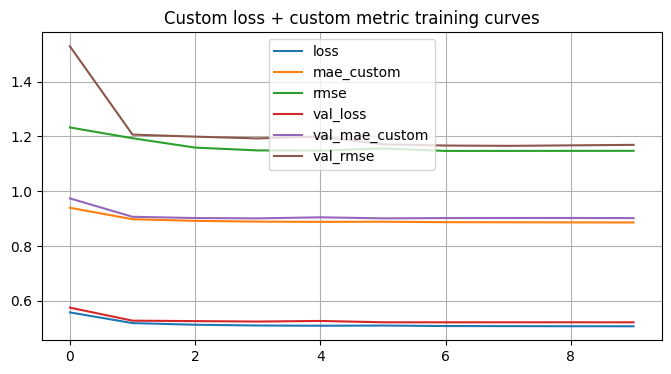

In [ ]:
huber_model = keras.models.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(1)
])

huber_model.compile(
    loss=HuberLoss(threshold=1.0),
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=[MeanAbsoluteErrorMetric(), keras.metrics.RootMeanSquaredError(name="rmse")]
)

huber_hist = huber_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_valid, y_valid),
    verbose=0
)

pd.DataFrame(huber_hist.history).plot(figsize=(8, 4), grid=True, title="Custom loss + custom metric training curves")
plt.show()

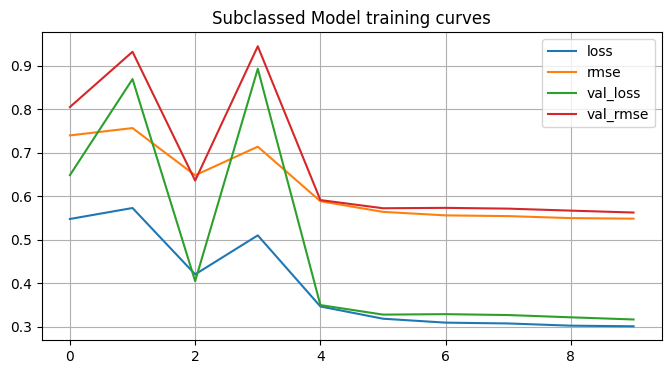

In [ ]:
class MyMLPRegressor(keras.Model):
    def __init__(self, n_hidden=2, n_neurons=30, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="relu", kernel_initializer="he_normal")
                       for _ in range(n_hidden)]
        self.out = keras.layers.Dense(1)

    def call(self, inputs, training=False):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        return self.out(x)

subclass_model = MyMLPRegressor(n_hidden=2, n_neurons=30)
subclass_model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=[keras.metrics.RootMeanSquaredError(name="rmse")]
)

sub_hist = subclass_model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=0)
pd.DataFrame(sub_hist.history).plot(figsize=(8, 4), grid=True, title="Subclassed Model training curves")
plt.show()

In [ ]:
# Build a simple model for the custom loop
loop_model = keras.models.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(1)
])

loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.01)

train_rmse = keras.metrics.RootMeanSquaredError()
val_rmse = keras.metrics.RootMeanSquaredError()

In [ ]:
batch_size = 64
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000, seed=42).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(batch_size)

def train_one_epoch(model, dataset):
    train_rmse.reset_state()
    for X_batch, y_batch in dataset:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            loss_value = loss_fn(y_batch, y_pred)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_rmse.update_state(y_batch, y_pred)
    return float(train_rmse.result())

def evaluate(model, dataset):
    val_rmse.reset_state()
    for X_batch, y_batch in dataset:
        y_pred = model(X_batch, training=False)
        val_rmse.update_state(y_batch, y_pred)
    return float(val_rmse.result())


# Run a few epochs
history_loop = {"train_rmse": [], "val_rmse": []}
for epoch in range(1, 11):
    tr = train_one_epoch(loop_model, train_ds)
    va = evaluate(loop_model, val_ds)
    history_loop["train_rmse"].append(tr)
    history_loop["val_rmse"].append(va)
    print(f"Epoch {epoch:02d} | train_rmse={tr:.4f} | val_rmse={va:.4f}")

Epoch 01 | train_rmse=0.8202 | val_rmse=0.6421
Epoch 02 | train_rmse=0.6356 | val_rmse=0.6866
Epoch 03 | train_rmse=0.5994 | val_rmse=0.7523
Epoch 04 | train_rmse=0.5963 | val_rmse=0.6155
Epoch 05 | train_rmse=0.5994 | val_rmse=0.6164
Epoch 06 | train_rmse=0.6336 | val_rmse=0.6938
Epoch 07 | train_rmse=0.6042 | val_rmse=1.2006
Epoch 08 | train_rmse=0.5927 | val_rmse=0.5893
Epoch 09 | train_rmse=0.5481 | val_rmse=0.8435
Epoch 10 | train_rmse=0.5553 | val_rmse=0.5692


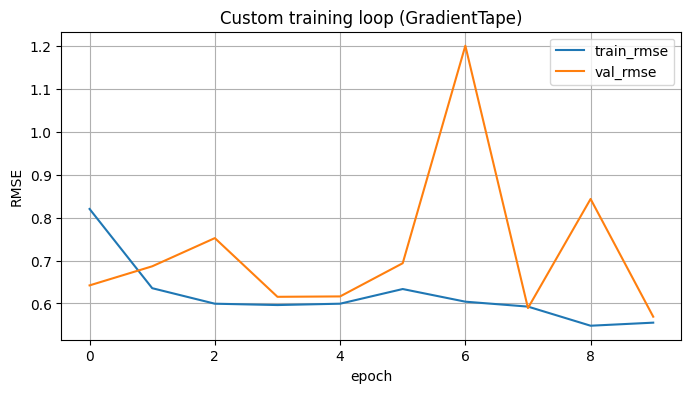

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history_loop["train_rmse"], label="train_rmse")
plt.plot(history_loop["val_rmse"], label="val_rmse")
plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.title("Custom training loop (GradientTape)")
plt.legend()
plt.show()

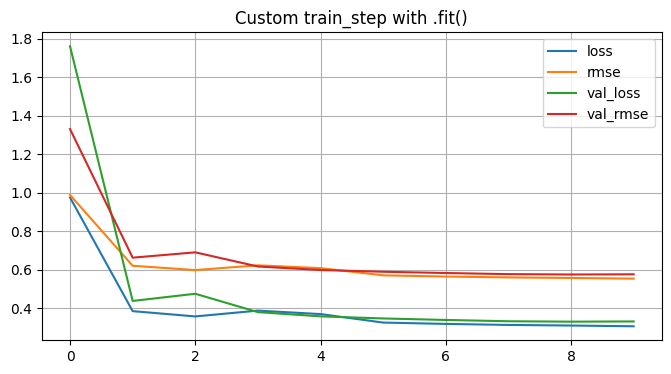

In [ ]:
class CustomTrainingModel(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dense1 = keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        self.dense2 = keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        self.out = keras.layers.Dense(1)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.rmse_tracker = keras.metrics.RootMeanSquaredError(name="rmse")

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.out(x)

    @property
    def metrics(self):
        return [self.loss_tracker, self.rmse_tracker]

    def train_step(self, data):
        X_batch, y_batch = data
        with tf.GradientTape() as tape:
            y_pred = self(X_batch, training=True)
            loss = tf.reduce_mean(tf.square(y_batch - tf.squeeze(y_pred)))
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.loss_tracker.update_state(loss)
        self.rmse_tracker.update_state(y_batch, y_pred)
        return {"loss": self.loss_tracker.result(), "rmse": self.rmse_tracker.result()}

    def test_step(self, data):
        X_batch, y_batch = data
        y_pred = self(X_batch, training=False)
        loss = tf.reduce_mean(tf.square(y_batch - tf.squeeze(y_pred)))
        self.loss_tracker.update_state(loss)
        self.rmse_tracker.update_state(y_batch, y_pred)
        return {"loss": self.loss_tracker.result(), "rmse": self.rmse_tracker.result()}

custom_step_model = CustomTrainingModel()
custom_step_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01))

custom_hist = custom_step_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10,
    batch_size=64,
    verbose=0
)

pd.DataFrame(custom_hist.history).plot(figsize=(8, 4), grid=True, title="Custom train_step with .fit()")
plt.show()

In [ ]:
save_path = "ch12_custom_layer_model.keras"
custom_layer_model.save(save_path)

loaded = keras.models.load_model(save_path, custom_objects={"MyDense": MyDense})
loaded.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_dense_1 (MyDense)            │ (None, 30)             │           270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_dense_2 (MyDense)            │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,695 (14.44 KB)

 Trainable params: 1,231 (4.81 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,464 (9.63 KB)

In [ ]:
# Quick evaluation on test set
loaded_eval = loaded.evaluate(X_test, y_test, verbose=0)
loaded_eval

[0.3105108141899109, 0.5572349429130554]